# VRP GraphNet

model inputs from the paper:

| Variable             | Meaning                           | Dimensions                |
|----------------------|-----------------------------------|---------------------------|
| batch_edges          | Adj matrix special connections*   | B x num_nodes x num_nodes |
| batch_edges_values   | Distance Matrix                   | B x num_nodes x num_nodes |
| batch_edges_target   | Target adj matrix                 | B x num_nodes x num_nodes |
| batch_nodes          | Ones vector                       | B x num_nodes             |
| batch_nodes_coord    | Coordinates                       | B x num_nodes x 2         |
| *batch_nodes_target* | Value represents ordering in tour | B x num_nodes             |


*special connections:
* 1 - k-nearest neighbour
* 2 - self connections
* 0 - otherwise

In [1]:
try:
    # noinspection PyUnresolvedReferences
    from google.colab import drive

    drive.mount("/content/gdrive")

    %cd gdrive/My Drive/vrp-thesis
    %pip install -r requirements-colab.txt
    IN_COLAB = True
except:
    IN_COLAB = False

In [2]:
if IN_COLAB:
    %reload_ext tensorboard
    %tensorboard --logdir runs

In [27]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from model import GraphNet
from utils import (
    load_config,
    get_metrics,
    get_device,
    save_checkpoint,
    DotDict,
    load_checkpoint,
)
from utils.beam_search import BeamSearch
from utils.data import load_and_split_dataset, process_datasets, adj_matrix_from_routes

sns.set_theme()

## Load datasets

In [4]:
dsets = load_and_split_dataset("data/vrp_20_3s_random_depot.pkl", test_size=500)
train_dataset, test_dataset = process_datasets(dsets, k=6)

print(len(train_dataset), len(test_dataset))

19500 500


## Basic Config

In [5]:
device = get_device()
print("Device", device)

Device cpu


In [6]:
default_config = load_config(
    hidden_dim=32,
    num_gcn_layers=5,
    num_mlp_layers=3,
    learning_rate=0.001,
    train_batch_size=128,
    test_batch_size=256,
    num_epochs=50,
)
default_config

{'hidden_dim': 32,
 'num_gcn_layers': 5,
 'num_mlp_layers': 3,
 'learning_rate': 0.001,
 'train_batch_size': 128,
 'test_batch_size': 256,
 'num_epochs': 50,
 'node_features': 3,
 'edge_distance_features': 1,
 'edge_types_features': 3,
 'dropout': None}

In [7]:
train_dataloader = DataLoader(
    train_dataset, batch_size=default_config.train_batch_size, shuffle=True
)

model = GraphNet(default_config).to(device)

## Test Forward Pass

In [8]:
features, _ = next(iter(train_dataloader))

y_pred = model.forward(
    features["node_features"].to(device),
    features["dist_matrix"].to(device),
    features["edge_feat_matrix"].to(device),
)

y_pred.shape

torch.Size([128, 21, 21, 2])

## Validation loop

In [9]:
def count_violations(tours, demands):
    """
    Count the number of violations per tour given the customer demands
    :param tours: (b, n) array of tours
    :param demands: (b, m) array of demands
    :return: (b,) array of count of violations
    """
    violations = np.zeros(tours.shape[0])

    for i in range(tours.shape[0]):
        count = 0
        running_load = 0

        for j in range(tours.shape[1]):
            node = tours[i, j]
            running_load += demands[i, node]

            if node == 0 or j == tours.shape[1] - 1:
                if running_load > 1:
                    count += 1
                running_load = 0

        violations[i] = count

    return violations


def shortest_valid_tour(
    y_preds, batch_dist_matrix, batch_node_features, num_vehicles, beam_width=1024
):
    # Move tensors to CPU for faster computation (due to loops and compare ops)
    y_preds = y_preds.cpu()
    batch_dist_matrix = batch_dist_matrix.cpu().numpy()
    batch_node_features = batch_node_features.cpu().numpy()

    y_preds = y_preds[..., 1]

    beamsearch = BeamSearch(y_preds, beam_width=beam_width, num_vehicles=num_vehicles)
    beamsearch.search()

    shortest_tour = np.zeros((beamsearch.batch_size, len(beamsearch.next_nodes)))
    shortest_tour_length = np.full((beamsearch.batch_size,), np.inf)
    max_violations = np.full((beamsearch.batch_size,), np.inf)

    for b in range(beamsearch.beam_width):
        # can probably be improved by moving to separate loop
        current_tour = beamsearch.get_beam(b)
        current_tour = current_tour.numpy()

        __adj_matrix = adj_matrix_from_routes(current_tour, batch_dist_matrix.shape[-1])
        tour_length = distance_from_adj_matrix(__adj_matrix, batch_dist_matrix)
        violations = count_violations(current_tour, batch_node_features[..., 2])

        for i in range(beamsearch.batch_size):
            # there are fewer violations, so we take it
            if violations[i] < max_violations[i]:
                shortest_tour[i] = current_tour[i]
                shortest_tour_length[i] = tour_length[i]
                max_violations[i] = violations[i]

            # same number of violations, take the shorter distance
            elif violations[i] == max_violations[i]:
                if tour_length[i] < shortest_tour_length[i]:
                    shortest_tour[i] = current_tour[i]
                    shortest_tour_length[i] = tour_length[i]

    return shortest_tour_length, shortest_tour, max_violations


def probable_tour_lengths(y_preds, batch_dist_matrix, num_vehicles, beam_width=1024):
    # only keep the probability of selecting the edge
    y_preds = y_preds[..., 1]

    beamsearch = BeamSearch(y_preds, beam_width=beam_width, num_vehicles=num_vehicles)
    beamsearch.search()

    tours = beamsearch.get_beam(0)
    tours = tours.cpu().numpy()

    __adj_matrix = adj_matrix_from_routes(tours, batch_dist_matrix.shape[-1])
    tour_lengths = distance_from_adj_matrix(__adj_matrix, batch_dist_matrix)

    return tour_lengths, tours


def greedy_tour_lengths(y_preds, batch_dist_matrix, num_vehicles):
    # only keep the probability of selecting the edge
    y_preds = y_preds[..., 1]

    beamsearch = BeamSearch(y_preds, beam_width=1, num_vehicles=num_vehicles)
    beamsearch.search()

    # get most probable tours (index = 0)
    tours = beamsearch.get_beam(0)
    tours = tours.cpu().numpy()

    __adj_matrix = adj_matrix_from_routes(tours, batch_dist_matrix.shape[-1])
    tour_lengths = distance_from_adj_matrix(__adj_matrix, batch_dist_matrix)

    return tour_lengths, tours


def eval_model(batch_node_features, batch_dist_matrix, batch_edge_features, model):
    model.eval()

    with torch.no_grad():
        preds = model(batch_node_features, batch_dist_matrix, batch_edge_features)
        preds = F.softmax(preds, dim=3)

        return preds


def validate(dataloader, model, criterion):
    running_loss = 0
    running_tour_lengths = []
    running_tour_violations = []
    targets = []
    predictions = []

    for batch_features, batch_targets in dataloader:
        batch_node_features = batch_features["node_features"].to(device)
        batch_dist_matrix = batch_features["dist_matrix"].to(device)
        batch_edge_features = batch_features["edge_feat_matrix"].to(device)
        # is this required??
        batch_num_vehicles = batch_features["num_vehicles"].to(device)
        batch_targets = batch_targets.to(device)

        y_preds = eval_model(
            batch_node_features, batch_dist_matrix, batch_edge_features, model=model
        )

        # Loss
        loss = get_loss(y_preds, batch_targets, criterion)
        running_loss += loss.item()

        # Tour lengths (mean per batch)
        for vehicles in torch.unique(batch_num_vehicles):
            mask = batch_num_vehicles == vehicles

            tour_lengths, tours = greedy_tour_lengths(
                y_preds[mask], batch_dist_matrix[mask], num_vehicles=vehicles
            )
            violations = count_violations(tours, batch_node_features[mask])

            running_tour_violations.extend(violations.cpu().numpy())
            running_tour_lengths.extend(tour_lengths.cpu().numpy())

        y_preds = y_preds.argmax(dim=3)
        y_preds = y_preds.cpu().numpy()

        targets.append(batch_targets.cpu().numpy())
        predictions.append(y_preds)

    targets = np.concatenate(targets)
    predictions = np.concatenate(predictions)
    mean_running_loss = running_loss / len(dataloader)

    running_tour_lengths = np.mean(running_tour_lengths)
    running_tour_violations = np.mean(running_tour_violations)

    return (
        targets,
        predictions,
        mean_running_loss,
        running_tour_lengths,
        running_tour_violations,
    )

## Training Loop

In [10]:
def get_loss(preds, targets, criterion):
    preds_perm = preds.permute(0, 3, 1, 2)

    return criterion(preds_perm, targets)


def train_one_epoch(dataloader, model, optimizer, criterion):
    running_loss = 0

    model.train()

    for batch_idx, (batch_features, batch_targets) in enumerate(dataloader):
        optimizer.zero_grad()

        batch_node_features = batch_features["node_features"].to(device)
        batch_dist_matrix = batch_features["dist_matrix"].to(device)
        batch_edge_features = batch_features["edge_feat_matrix"].to(device)
        batch_targets = batch_targets.to(device)

        preds = model(batch_node_features, batch_dist_matrix, batch_edge_features)
        loss = get_loss(preds, batch_targets, criterion)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()

    return running_loss


def train(num_epochs, train_dl, test_dl, model, optimizer, criterion, writer):
    best_loss = np.inf

    for epoch in range(num_epochs):
        # Train
        running_loss = train_one_epoch(
            train_dl, model=model, optimizer=optimizer, criterion=criterion
        )

        # Losses
        epoch_loss = running_loss / len(train_dl)

        # Validation Metrics
        targets, predictions, validation_loss, tour_length, violations = validate(
            test_dl, model=model, criterion=criterion
        )
        metrics = get_metrics(targets, predictions)

        writer.add_scalar("Metrics/accuracy", metrics.acc, epoch)
        writer.add_scalar("Metrics/bal. accuracy", metrics.bal_acc, epoch)
        writer.add_scalar("Metrics/precision", metrics.precision, epoch)
        writer.add_scalar("Metrics/recall", metrics.recall, epoch)
        writer.add_scalar("Metrics/f1 score", metrics.f1_score, epoch)
        writer.add_scalar("Metrics/tour length", tour_length, epoch)
        writer.add_scalar("Metrics/violations", violations, epoch)

        writer.add_scalar("Loss/train", epoch_loss, epoch)
        writer.add_scalar("Loss/test", validation_loss, epoch)

        # Save (validation) checkpoint
        if validation_loss < best_loss:
            best_loss = validation_loss
            save_checkpoint(
                writer.log_dir / "best_validation_loss_model.pt",
                model=model,
                optimizer=optimizer,
                epoch=epoch,
                config={**config},
                train_loss=epoch_loss,
                test_loss=validation_loss,
            )

        # Save (epoch) checkpoint
        save_checkpoint(
            writer.log_dir / "last_epoch_model.pt",
            model=model,
            optimizer=optimizer,
            epoch=epoch,
            config={**config},
            train_loss=epoch_loss,
            test_loss=validation_loss,
        )

        print(f"Epoch: {epoch:02d}, Loss: {epoch_loss:.4f}")

## Baseline Model

In [ ]:
LOG_DIR = Path(f"runs/exp_baseline_3")

config = load_config(**default_config)
# config.hidden_dim = 128
# config.gcn_layers = 10
config.num_epochs = 10

train_dataloader = DataLoader(
    train_dataset, batch_size=config.train_batch_size, shuffle=True
)
test_dataloader = DataLoader(
    test_dataset, batch_size=config.test_batch_size, shuffle=True
)

torch.manual_seed(0)

edge_class_weights = train_dataset.class_weights().to(device)
model = GraphNet(config).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
criterion = nn.CrossEntropyLoss(edge_class_weights)

writer = SummaryWriter(log_dir=LOG_DIR)

train(
    config.num_epochs,
    train_dl=train_dataloader,
    test_dl=test_dataloader,
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    writer=writer,
)
writer.flush()
writer.close()

## Plot Results

In [11]:
MODEL_PATH = Path("runs/exp_baseline")

checkpoint = load_checkpoint(MODEL_PATH / "last_epoch_model.pt")
config = DotDict(checkpoint["config"])
model = GraphNet(config).to(device)

model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [110]:
test_dataloader = DataLoader(
    test_dataset, batch_size=config.test_batch_size, shuffle=True
)
batch_features, batch_targets = next(iter(test_dataloader))

In [111]:
batch_node_features = batch_features["node_features"].to(device)
batch_dist_matrix = batch_features["dist_matrix"].to(device)
batch_edge_features = batch_features["edge_feat_matrix"].to(device)
batch_targets = batch_targets.to(device)

batch_num_vehicles = batch_features["num_vehicles"].cpu().numpy()

preds = eval_model(
    batch_node_features, batch_dist_matrix, batch_edge_features, model=model
)

In [112]:
import importlib
import utils.beam_search

importlib.reload(utils.beam_search)

BeamSearch = utils.beam_search.BeamSearch

In [88]:
bs = BeamSearch(preds[:5, ..., 1], beam_width=1, num_vehicles=2)

tensor([[[0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1.]],

        [[0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1.]],

        [[0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1.]],

        [[0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1.]],

        [[0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1.]]])


In [101]:
bs.next_nodes

[tensor([[0],
         [0],
         [0],
         [0],
         [0]]),
 tensor([[11],
         [ 1],
         [17],
         [18],
         [17]]),
 tensor([[19],
         [18],
         [18],
         [ 9],
         [ 9]]),
 tensor([[ 7],
         [ 0],
         [ 0],
         [ 0],
         [18]]),
 tensor([[ 0],
         [12],
         [13],
         [10],
         [ 4]])]

In [102]:
bs.mask

tensor([[[0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
          1., 1., 0., 1.]],

        [[0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
          1., 0., 1., 1.]],

        [[0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
          0., 0., 1., 1.]],

        [[0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1.,
          1., 0., 1., 1.]],

        [[1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
          0., 0., 1., 1.]]])

In [103]:
bs.step()

tensor([[[0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
          1., 1., 0., 1.]],

        [[0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
          1., 0., 0., 1.]],

        [[0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
          0., 0., 0., 1.]],

        [[0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0.,
          1., 0., 1., 1.]],

        [[1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
          0., 0., 1., 0.]]])


In [104]:
for i in range(5):
    print(f"step {i}")
    bs.step()
    print()

step 0
tensor([[[0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1.,
          1., 1., 0., 1.]],

        [[0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1.,
          1., 0., 0., 1.]],

        [[0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1.,
          0., 0., 0., 1.]],

        [[0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0.,
          1., 0., 1., 1.]],

        [[1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
          0., 0., 1., 0.]]])

step 1
tensor([[[0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1.,
          1., 1., 0., 1.]],

        [[0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1.,
          1., 0., 0., 0.]],

        [[0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1.,
          0., 0., 0., 1.]],

        [[0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0.,
          1., 0., 1., 1.]],

        [[1., 0., 1., 

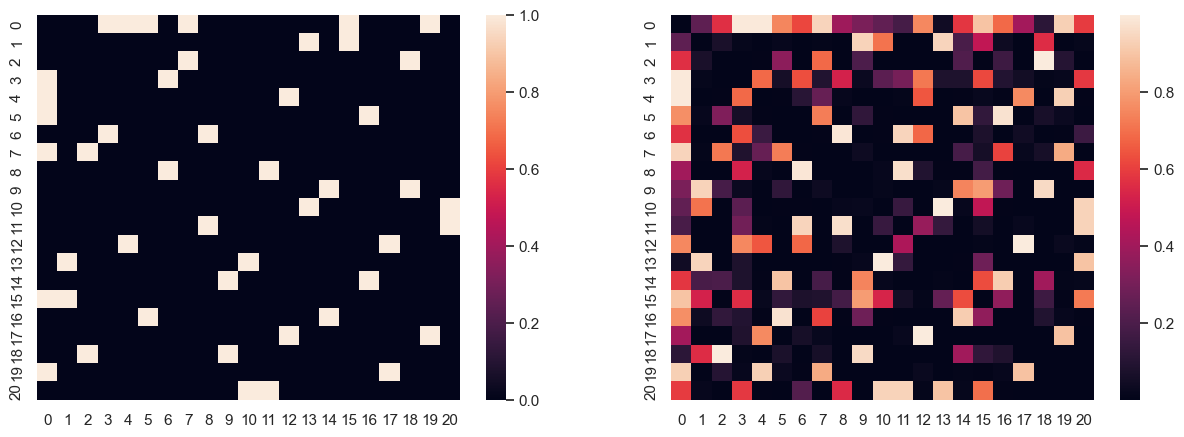

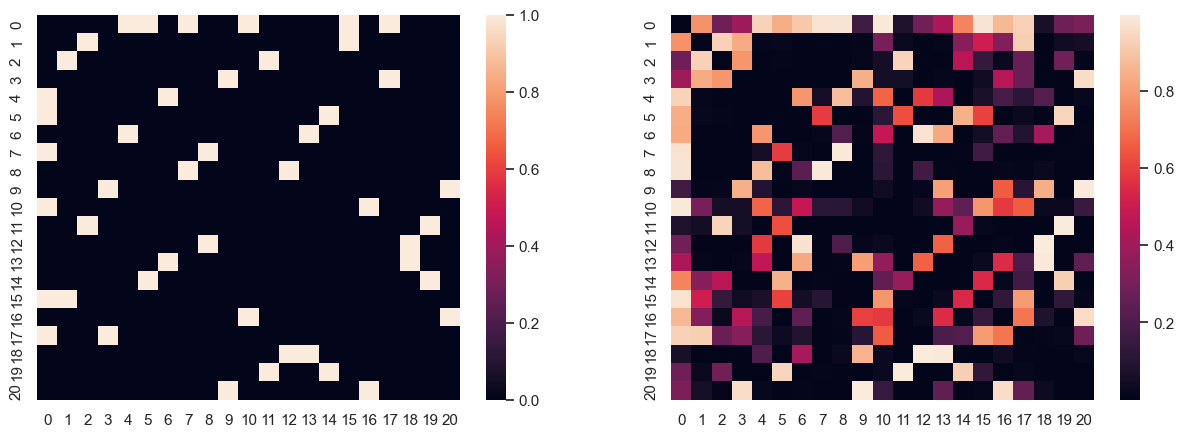

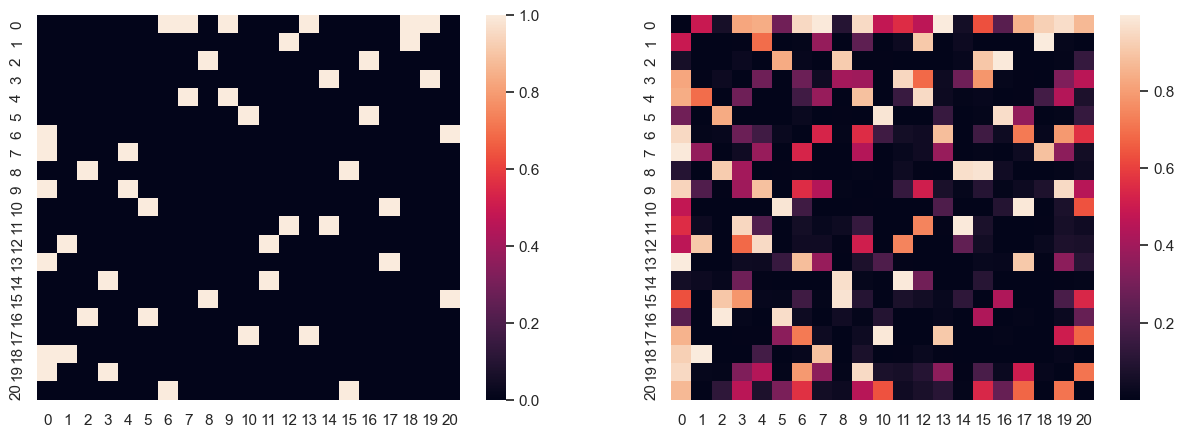

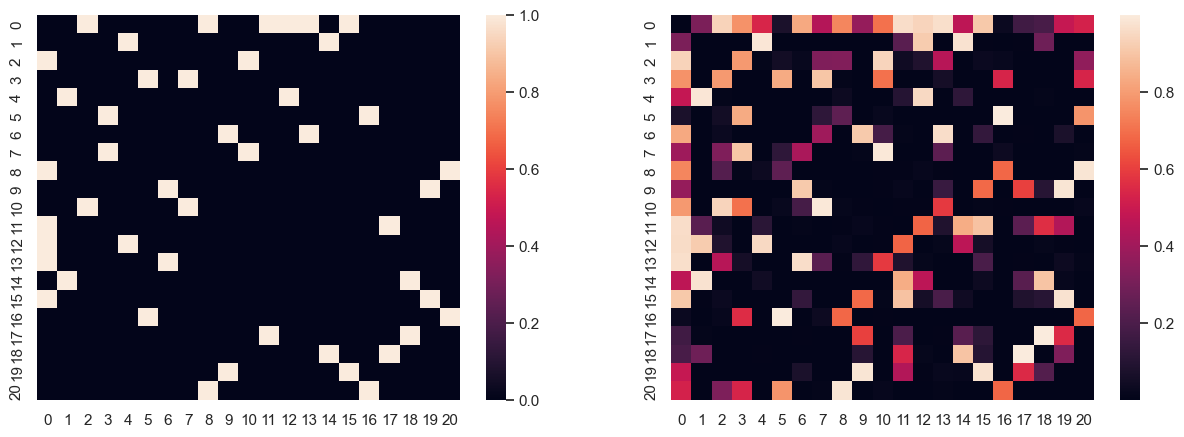

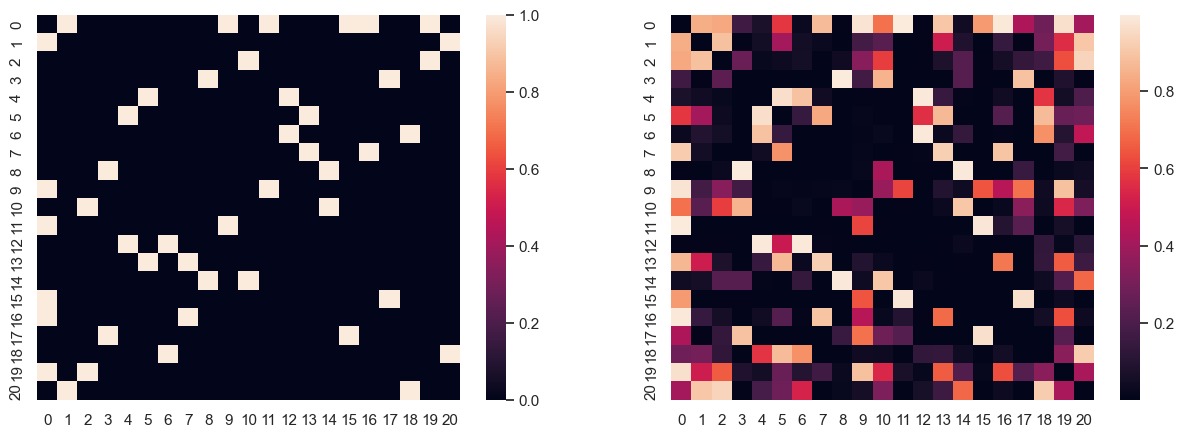

In [32]:
for c in np.random.choice(len(batch_node_features), 5):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    sns.heatmap(batch_targets[c].cpu().numpy(), ax=ax[0])
    sns.heatmap(preds[c, ..., 1].cpu().numpy(), ax=ax[1])

    plt.show()

Sample 19
Violations: 0.0


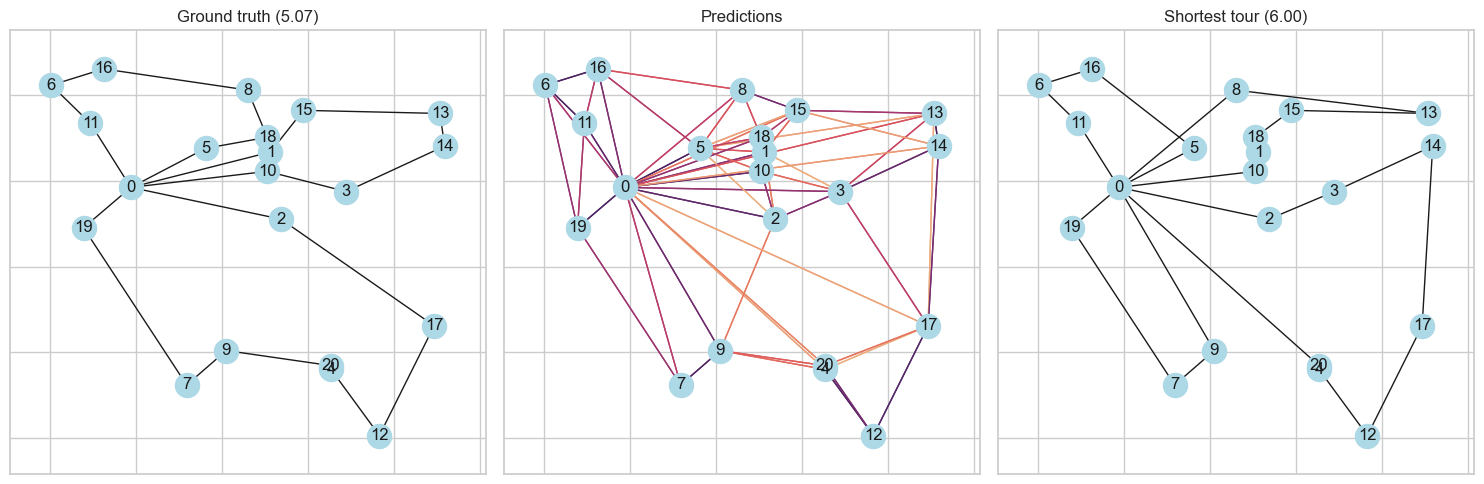

Sample 30
Violations: 1.0


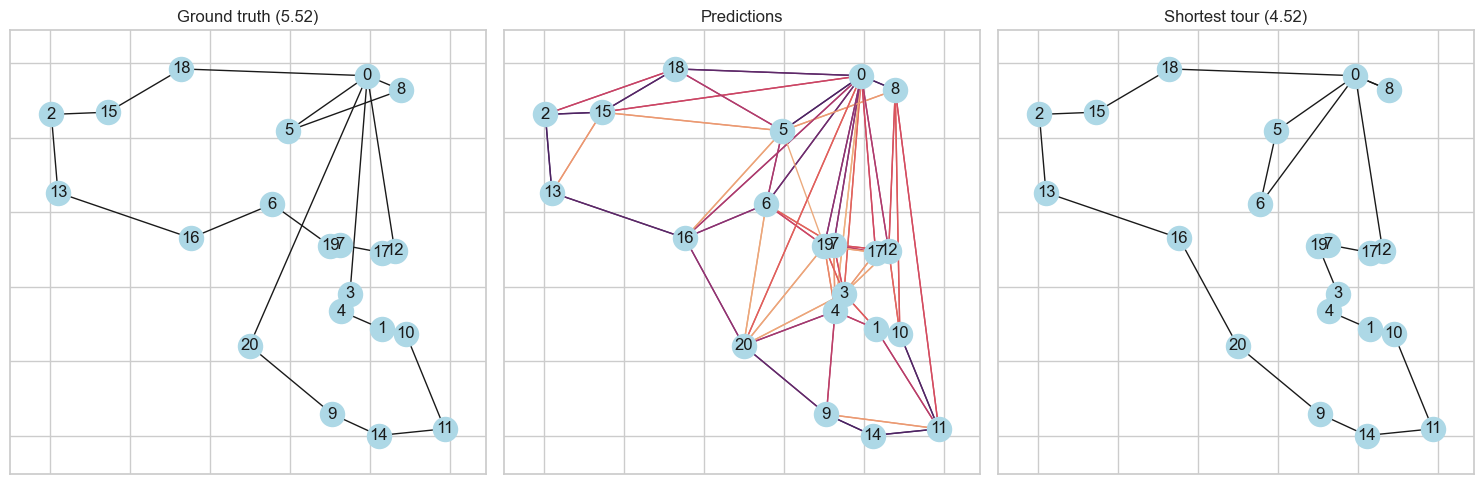

Sample 32
Violations: 0.0


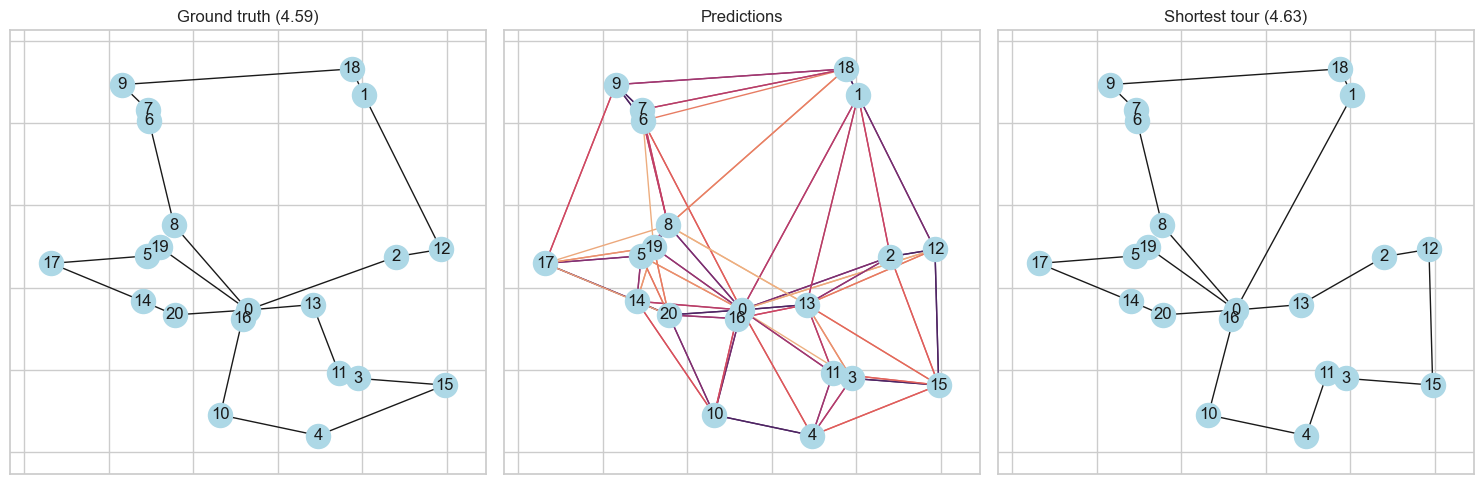

Sample 63
Violations: 0.0


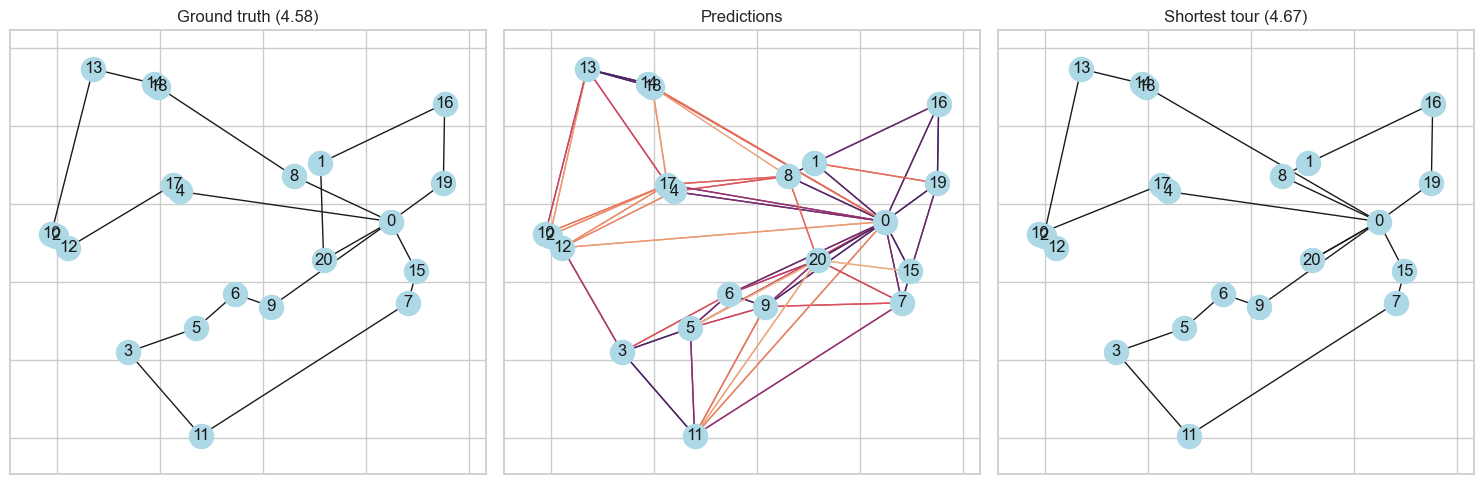

Sample 48
Violations: 0.0


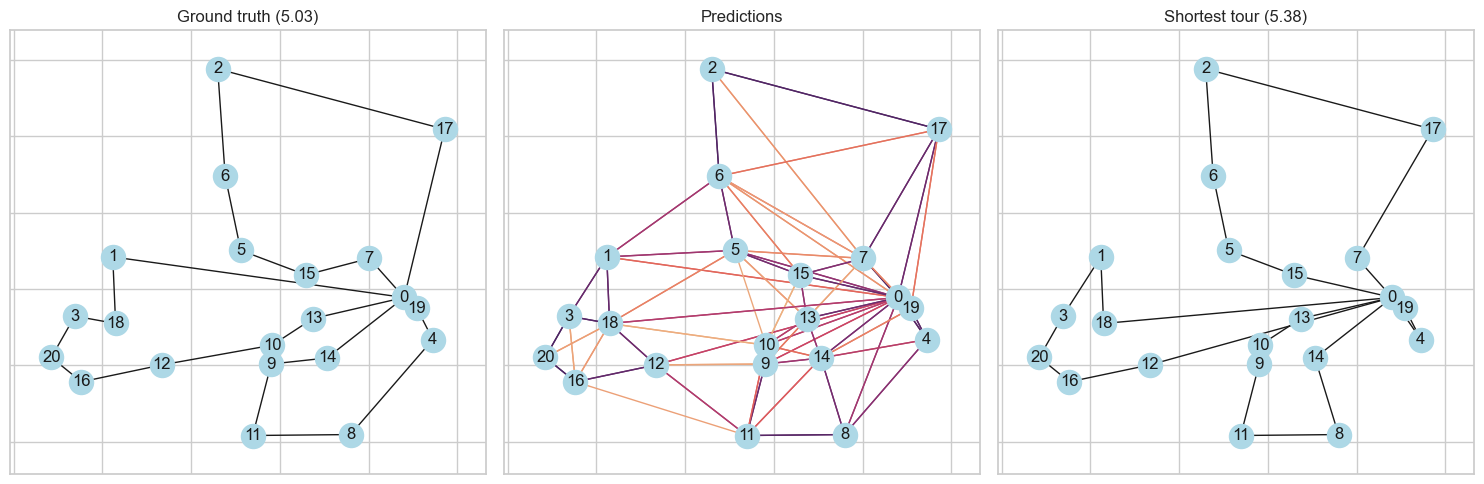

Sample 37
Violations: 1.0


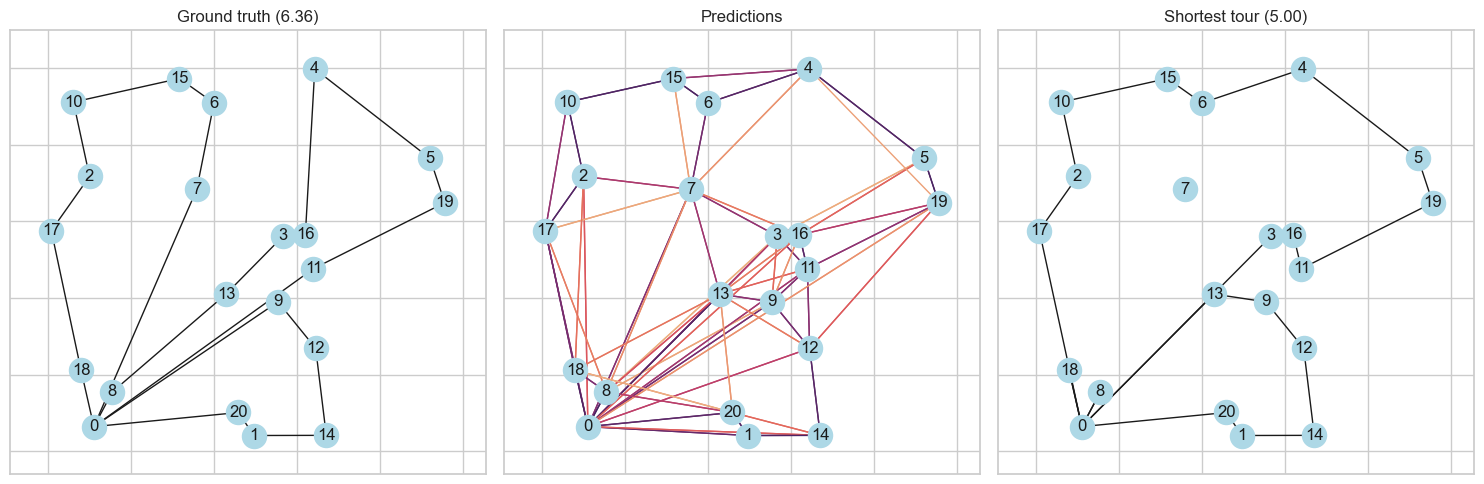

Sample 41
Violations: 1.0


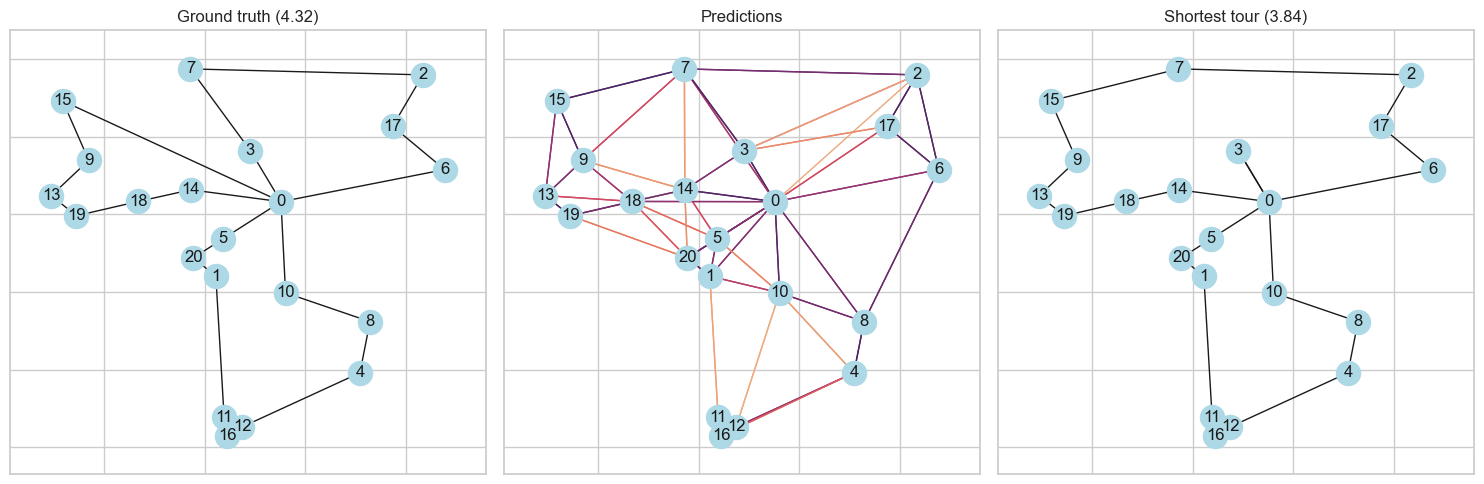

Sample 56
Violations: 0.0


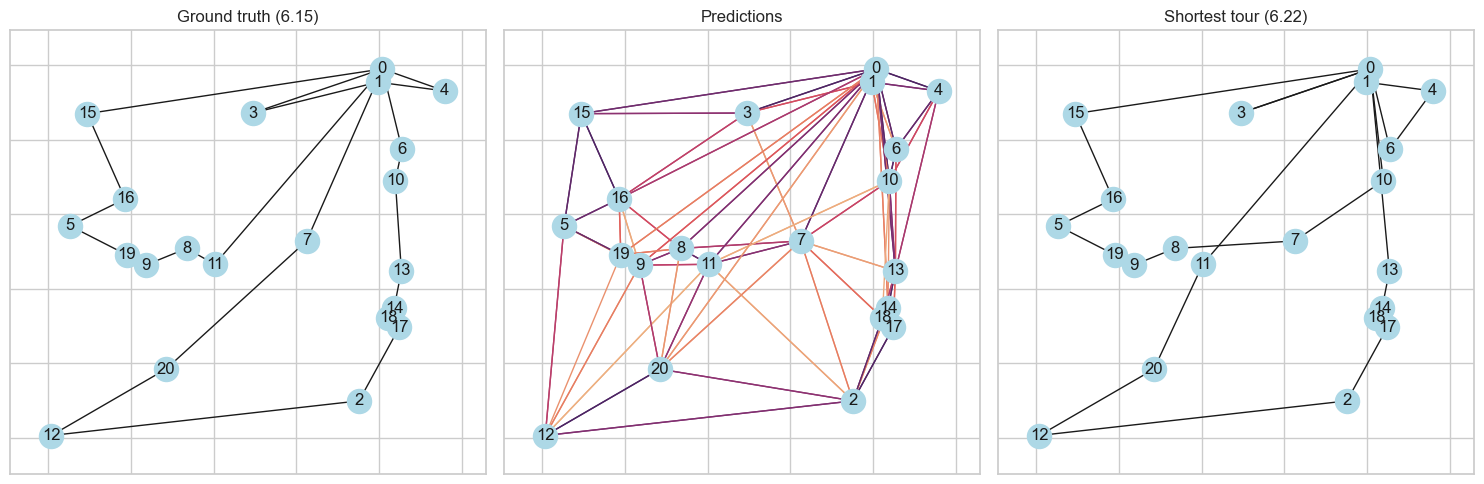

Sample 30
Violations: 1.0


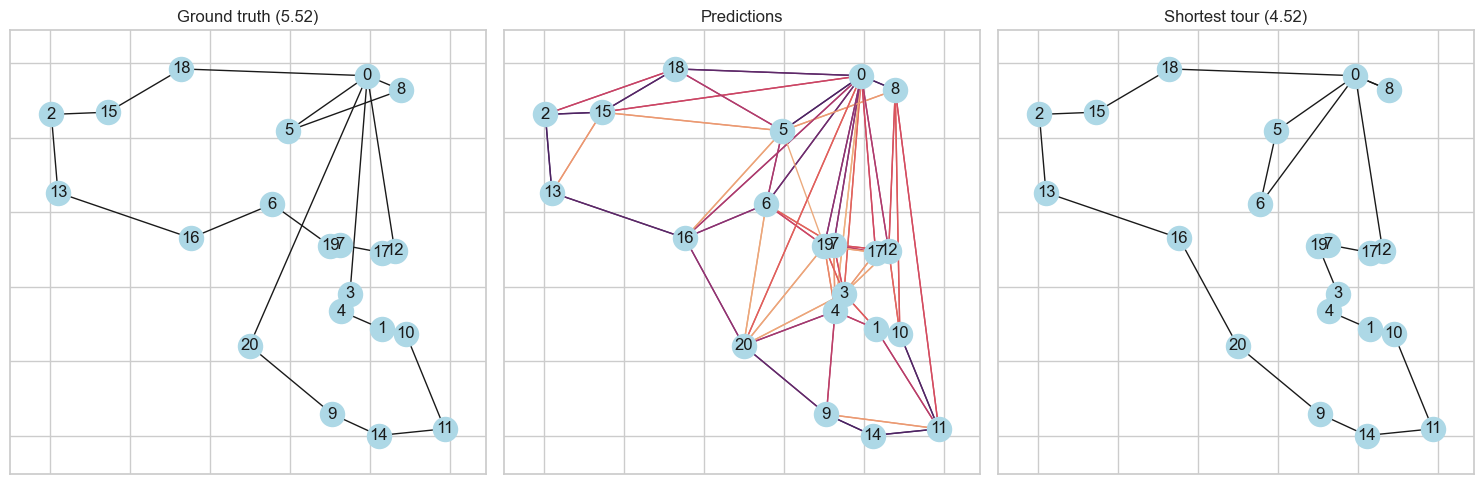

Sample 4
Violations: 0.0


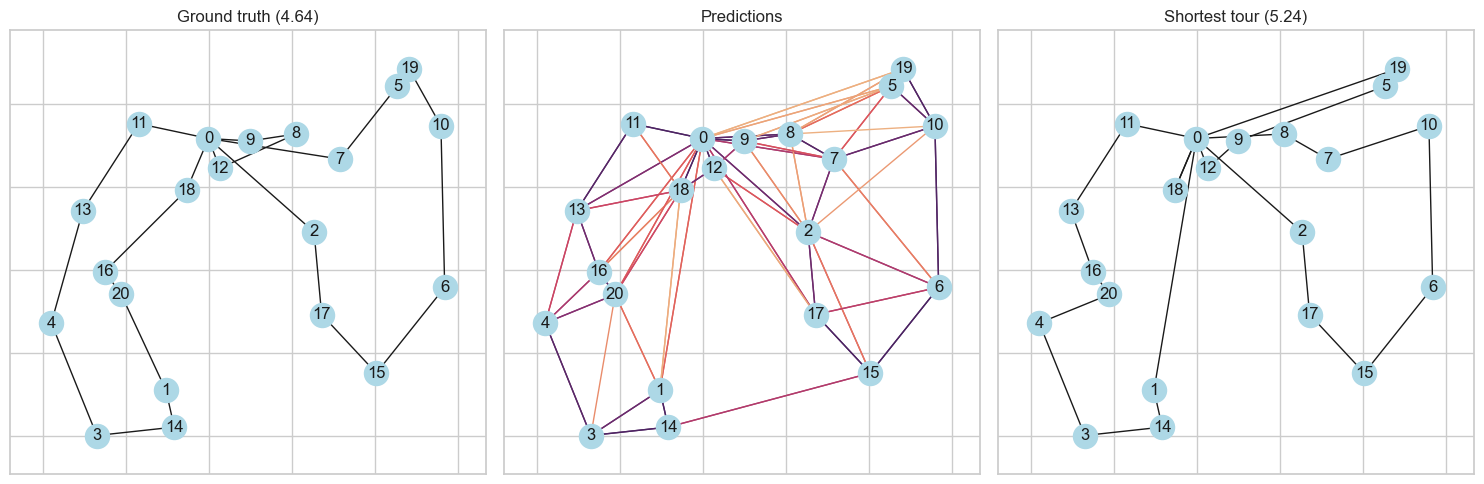

In [117]:
from utils.plot import plot_graph, plot_heatmap, plot_beam_search_tour
from utils.data import distance_from_adj_matrix
import matplotlib.pyplot as plt

NUM_SAMPLES = 10
# max_num_vehicles = np.max(batch_num_vehicles)
max_num_vehicles = 4

actual_distance = distance_from_adj_matrix(batch_targets, batch_dist_matrix)
distances, routes, violations = shortest_valid_tour(
    preds, batch_dist_matrix, batch_node_features, max_num_vehicles, 2048
)

actual_distance = actual_distance.cpu().numpy()
node_features = batch_node_features.cpu().numpy()
targets = batch_targets.cpu().numpy()
predictions = preds[..., 1].cpu().numpy()

for i in np.random.choice(len(node_features), NUM_SAMPLES):
    print(f"Sample {i}")
    print(f"Violations: {violations[i]}")
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    plot_graph(node_features[i, :, :2], targets[i], ax=ax[0])
    plot_heatmap(node_features[i, :, :2], targets[i], predictions[i], ax=ax[1])
    plot_beam_search_tour(node_features[i, :, :2], targets[i], routes[i], ax=ax[2])

    ax[0].set_title(f"Ground truth ({actual_distance[i]:.2f})")
    ax[1].set_title("Predictions")
    ax[2].set_title(f"Shortest tour ({distances[i]:.2f})")
    fig.tight_layout()

    plt.show()